# Рекомендация тарифов

## Описание проекта

Есть данные о поведении клиентов, которые перешли на определенные тарифы. Нужно построить модель, которая выберет подходящий тариф для новых пользователей. Предобработка данных не нужна.

## Анализ данных

In [1]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn import (tree, model_selection, ensemble, linear_model, metrics, dummy)

Загрузим данные

In [2]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/users_behavior.csv')

In [3]:
data.head(15)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


Исходя их таблицы, целевой признак - "is_ultra", он бинарный. Тогда стоит отнести задачу к задаче классификации, т.к. происходит выбор между двумя категориями.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


В данных нет пропусков

In [5]:
data.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


У целевого признака среднее значение ближе к 0, проверим, сколько 0 и 1

In [6]:
print(data.query('is_ultra == 1')['is_ultra'].count())
print(data.query('is_ultra == 0')['is_ultra'].count())
print(data.query('is_ultra == 0')['is_ultra'].count()/data.query('is_ultra == 1')['is_ultra'].count())

985
2229
2.2629441624365483


В целевом признаке присутствует дисбаланс в сторону 0. Нулей 69%, значит, модель должна превзойти значение accuracy 0,69, чтобы быть признанной адекватной.

In [7]:
data.corr()

,calls,minutes,messages,mb_used,is_ultra
calls,1.000000,0.982083,0.177385,0.286442,0.207122
minutes,0.982083,1.000000,0.173110,0.280967,0.206955
messages,0.177385,0.173110,1.000000,0.195721,0.203830
mb_used,0.286442,0.280967,0.195721,1.000000,0.198568
is_ultra,0.207122,0.206955,0.203830,0.198568,1.000000


Между звонками и минутами есть прямая зависимость, но в логистической и в линейной регрессиях реализована регуляризация, которая решает проблему мультиколлинеарности признаков. Деревья также устойчивы к мультиколлинеарности. Получается, избавляться от мультиколлинеарности, чтобы не переобучаться, не обязательно.

## Обучение модели

In [8]:
rand=12345

Разделим данные на тренировочную и тестовую выборки, так как у нас нет "спрятанной" тестовой выборки, и надо, соответственно, делить в отношении 3:1:1

In [9]:
data_train, data_test = model_selection.train_test_split(data, test_size=0.2, random_state=12345)
features = data_train.drop(['is_ultra','minutes'], axis=1)
features

,calls,messages,mb_used
348,77.0,14.0,19462.45
1172,144.0,99.0,40174.34
2315,48.0,0.0,19000.02
954,52.0,40.0,24574.82
2918,77.0,100.0,10518.28
...,...,...,...
2817,12.0,22.0,36628.85
546,65.0,0.0,15214.25
382,144.0,0.0,25002.44
2177,38.0,37.0,28914.24


In [10]:
target = data_train['is_ultra']
target

348     0
1172    1
2315    0
954     0
2918    1
       ..
2817    1
546     1
382     1
2177    1
482     1
Name: is_ultra, Length: 2571, dtype: int64

Делим тренировочную выборку на обучающую и валидационную

In [11]:
features_train, features_valid, target_train, target_valid = model_selection.train_test_split(features, target, 
                                                                              test_size=0.25, random_state=12345, stratify=target)

На данный момент мне известно три основных модели, подходящие для классификации: дерево решений, случайный лес и логистическая регрессия. Сначала посмотрю, какая из моделей без настроек гиперпараметров показывает лучший результат в точности 

In [12]:
models = [tree.DecisionTreeClassifier(random_state=rand), 
          ensemble.RandomForestClassifier(random_state=rand), linear_model.LogisticRegression(random_state=12345)]
names = ['Дерево решений', 'Случайный лес', 'Логистическая регрессия']

Лучше всего справляется с задачей случайный лес. Посмотрим, могут ли другие модели при подборе гиперпараметров выдать более хороший результат. Попробуем подобрать количество итераций для логистической регрессии.

Наиболее подходящее количество итераций: 100
Точность: 0.7558320373250389


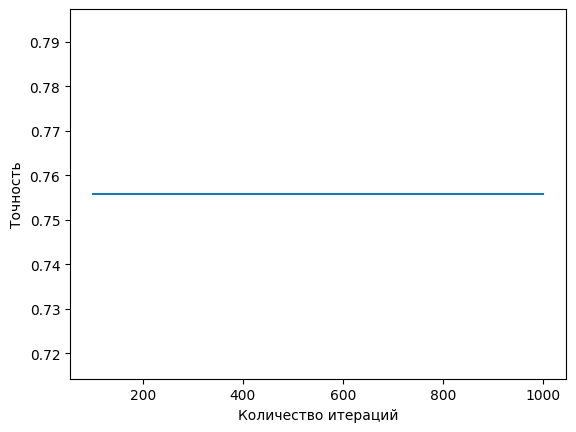

In [13]:
iterations = [100, 250, 500, 800, 1000]
acur_plot = []
best_iter = 0
best_accuracy = 0
for iteration in iterations:
    model = linear_model.LogisticRegression(random_state=12345, max_iter=iteration)
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    accuracy = metrics.accuracy_score(target_valid, predictions_valid)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_iter = iteration
    acur_plot.append(accuracy)
print('Наиболее подходящее количество итераций:', best_iter)
print('Точность:', best_accuracy)
plt.plot(iterations, acur_plot)
plt.ylabel('Точность')
plt.xlabel('Количество итераций');

Количество итераций не помогает улучшить точность модели.

Попробуем подобрать гиперпараметры для дерева решений

Наиболее подходящая глубина дерева: 12
Точность: 0.8087091757387247


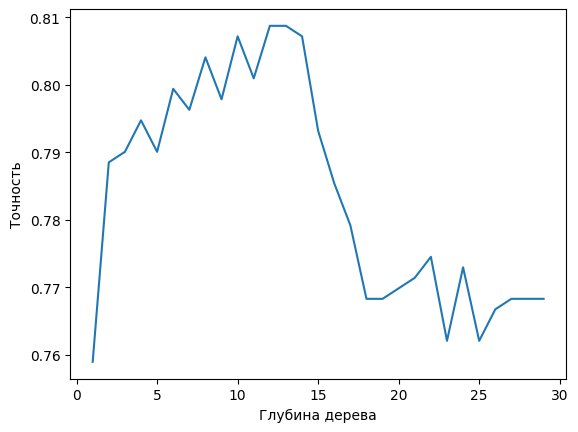

In [14]:
best_depth = 0
best_accuracy = 0
acur_plot = []
for i in range(1,30):
    model = tree.DecisionTreeClassifier(random_state=12345, max_depth=i)
    model.fit(features_train, target_train)
    predictions_valid = model.predict(features_valid)
    accuracy = metrics.accuracy_score(target_valid, predictions_valid)
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_depth = i
    acur_plot.append(accuracy)
print('Наиболее подходящая глубина дерева:', best_depth)
print('Точность:', best_accuracy)
plt.plot(range(1,30), acur_plot)
plt.ylabel('Точность')
plt.xlabel('Глубина дерева');

При наблюдении за изменением точности модели можно увидеть, что точность резко увеличивается до глубины 3-4, далее уже более плавно до глубины 12, и затем резко падает с увилечением глубины деревьев, вероятно, из-за переобучения

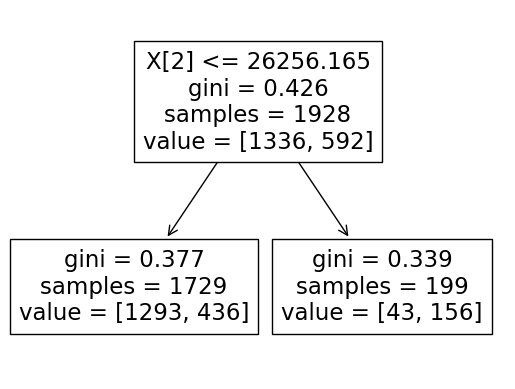

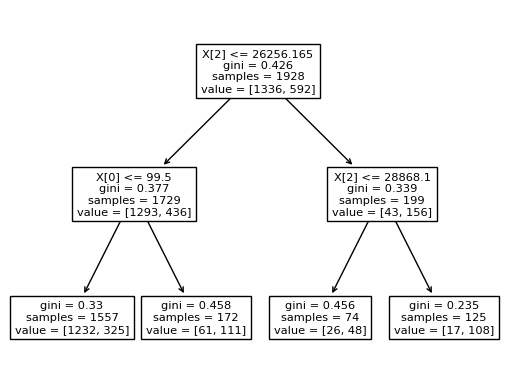

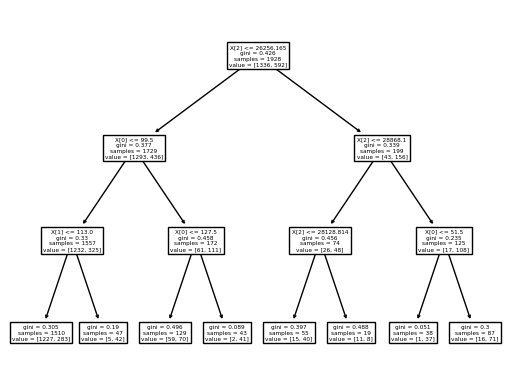

<Figure size 640x480 with 0 Axes>

In [15]:
for i in range(1,4):
    model = tree.DecisionTreeClassifier(random_state=12345, max_depth=i)
    model = model.fit(features_train, target_train)
    tree.plot_tree(model)
    plt.figure();

In [16]:
best_split = 0
best_leaf = 0
best_depth = 0
best_accuracy = 0
for i in range(1,15):
    for j in range(2,10):
        for k in range(1,10):
                model = tree.DecisionTreeClassifier(random_state=12345, min_samples_split=j, 
                                               min_samples_leaf=k,
                                               max_depth=i)
                model.fit(features_train, target_train)
                predictions_valid = model.predict(features_valid)
                accuracy = metrics.accuracy_score(target_valid, predictions_valid)
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_depth = i
                    best_split = j
                    best_leaf = k
print('Лучшие параметры: Глубина:', i, "split:", j, "leaf:", k)
print('Точность:', accuracy)

Лучшие параметры: Глубина: 14 split: 9 leaf: 9
Точность: 0.7884914463452566


При переборе параметров можно улучшить модель одного дерева с 0.77 до 0.79

В целом, подбор параметров для одиночного дерева не делает его лучше случайного леса. Тогда попробуем улучшить модель леса перебором.

In [17]:
best_est = 0
best_accuracy = 0
best_depth = 0
for i in tqdm(range(100, 1000, 100)):
    time.sleep(1)
    for j in range(1,20):
        model = ensemble.RandomForestClassifier(random_state=12345, n_estimators=i, max_depth=j)
        model.fit(features_train, target_train)
        predictions_valid = model.predict(features_valid)
        accuracy = metrics.accuracy_score(target_valid, predictions_valid)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_est = i
            best_depth = j
print('Наиболее подходящее количество решателей:', best_est)
print("Наиболее подходящая глубина деревьев:", best_depth)
print('Точность:', best_accuracy)

100%|██████████| 9/9 [02:58<00:00, 19.84s/it]

Наиболее подходящее количество решателей: 100
Наиболее подходящая глубина деревьев: 6
Точность: 0.8195956454121306


Итог: Суммарно, лучшая модель для данной выборки - это случайный лес. Логистическая регрессия показывает недостаточный показатель точности. Подбор гиперпараметров улучшает точность для дерева решений, но его точность получается все равно меньше, чем у случайного леса.

## Тестирование модели

Разделим тестовую выборку на признаки и целевой признак

In [18]:
features_test = data_test.drop(['is_ultra', 'minutes'], axis=1)
target_test = data_test['is_ultra']

Проверим на ней модель случайного леса с подобранным количеством решателей

In [19]:
model = ensemble.RandomForestClassifier(random_state=12345, n_estimators=100, max_depth=6)
model.fit(features_train, target_train)
predictions_test = model.predict(features_test)
accuracy = metrics.accuracy_score(target_test, predictions_test)
print('Точность:', accuracy)

Точность: 0.7853810264385692


Точность модели на тестовой выборке близка к точности на обучающей и валидационной и превышает 0.75

Теперь попробуем обучить модель на валидационной+тестовой выборке, чтобы узнать, увеличится ли точность при большем количестве данных для обучения

In [20]:
features_test_val = pd.concat([features_train, features_valid])
target_test_val = pd.concat([target_train, target_valid])

In [21]:
model = ensemble.RandomForestClassifier(random_state=12345, n_estimators=100, max_depth=6)
model.fit(features_test_val, target_test_val)
predictions_test = model.predict(features_test)
accuracy = metrics.accuracy_score(target_test, predictions_test)
print('Точность:', accuracy)

Точность: 0.7916018662519441


Действительно, точность предсказания модели по тестовой выборке увеличилась

## Проверка модели на адекватность

In [22]:
model = dummy.DummyClassifier(strategy='most_frequent', random_state=12345)
model.fit(features_test_val, target_test_val)
model.score(target_test, predictions_test)

0.8133748055987559

## Выводы

Итог:
- В данном случае наиболее подходящей оказалась модель случайного леса, что, в целом, логично, так как у него более высокое качество оценки относительно других рассмотренных моделей. Так как датасет небольшой, в данном случае использование случайного леса целесообразно и не вызывает проблем, связанных с временем обработки данных;
- Подбор гиперпараметров не помог достичь более высокой точности для других моделей, чем у леса, но немного повысил точность модели случайного леса;
- Точность полученной модели на валидационном наборе данных 0.82, на тестовом - 0.78, что согласуется и больше 0.75
- Фиктивный классификатор предсказывает лучше модели